# Single section blob detection
use global gradient match threshold 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 1
%reload_ext autoreload

import sys, os, time

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'cells'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'annotation'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'learning'))

import numpy as np
from skimage.measure import regionprops
from skimage.filters import threshold_otsu
from scipy.ndimage.morphology import distance_transform_edt
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.transform import resize
from skimage.color import rgb2hsv
from scipy import ndimage as ndi
import pandas
from scipy.signal import argrelmax
from scipy.stats import linregress
import scipy

from annotation_utilities import *
from registration_utilities import *
from learning_utilities import *
from data_manager import *



Setting environment for AWS compute node


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


In [2]:
%autoreload 1
save_folder_path = '/shared/MouseBrainAtlasXiang/XJ/Output/Bolb_detection_single_sec/'
from xj_utilities import *
fun_create_folder(save_folder_path=save_folder_path)

Folder already exists: /shared/MouseBrainAtlasXiang/XJ/Output/Bolb_detection_single_sec/

In [3]:
stack = 'MD589'
metadata_cache['section_limits'][stack]
patch_size = 448
patch_half_size = patch_size / 2
stride = 112
# Crop images
# 
crop_x_min = 9000
crop_x_max = 10500
crop_y_min = 3000
crop_y_max = 4500

# Inside
# crop_x_min = 4000
# crop_x_max = 6000
# crop_y_min = 2400
# crop_y_max = 4400

# Whole
# crop_x_min = 0
# crop_y_min = 0
# _, _, crop_y_max, crop_x_max = get_default_gridspec(stack=stack, patch_size=patch_size, stride=stride)

crop_image_width = crop_y_max - crop_y_min
crop_image_height = crop_x_max - crop_x_min

def get_filename(define_list):
    """
    get_finelname(list_of_definition_component): return a string concaining filename definition, seperated by '_' 
    """
    filename_head = ''
    for filename_element in map(str,define_list):
        filename_head = filename_head + filename_element + '_'
    return filename_head

patch_center_pixel_location = grid_parameters_to_sample_locations((patch_size, stride, crop_image_width, crop_image_height ))
patch_ul = patch_center_pixel_location + ( - patch_half_size, - patch_half_size )
patch_ur = patch_center_pixel_location + ( - patch_half_size,   patch_half_size )
patch_dl = patch_center_pixel_location + (   patch_half_size, - patch_half_size )
patch_dr = patch_center_pixel_location + (   patch_half_size,   patch_half_size )
patch_contour = np.array(zip(patch_ul, patch_ur, patch_dr, patch_dl))

# Options
option_rescale_grayscale = True
option_THimage_save = True;
option_save_image_extension = '.png'

# Process images
option_label_connectivity = 4;

In [4]:
# Set examine section number range and download from S3 if not available
img_filename = []
secIndexList = range(200, 201)

for tempIndex1 in range(len(secIndexList)):
    img_filename.append(DataManager.get_image_filepath(stack=stack, section=secIndexList[tempIndex1], resol='lossless', version='cropped'))
    if os.path.isfile(img_filename[tempIndex1]):
        sys.stderr.write('Image files are already available. \n')
        continue
    else:
        try:
            download_from_s3(img_filename[tempIndex1])
        except:
            sys.stderr.write('Download fail. Skip this file...\n')
            continue           


Image files are already available. 


In [5]:
im_cropped = []
for imIndex in img_filename:
# for imIndex in [img_filename[0]]:
     im_cropped.append(img_as_ubyte(rgb2gray(imread(imIndex)[crop_x_min:crop_x_max, crop_y_min:crop_y_max])))
    
im_cropped_h, im_cropped_w = im_cropped[0].shape[:2]

/usr/local/lib/python2.7/dist-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [6]:
option_rescale_grayscale = True
option_inverse_color = False
secIndex = 0

if option_rescale_grayscale:
    tempImage = fun_rescale_grayscale_image(im_cropped[secIndex],invcol=option_inverse_color)
else:
    tempImage = im_cropped[secIndex]

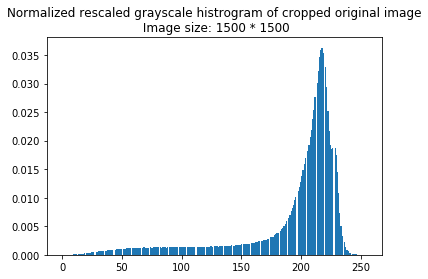

In [7]:
plt.hist(tempImage.flatten(), bins=256, normed=True);
plt.title('Normalized rescaled grayscale histrogram of cropped original image\n Image size: {} * {}'.format(crop_image_height, crop_image_width))
plt.show()

In [8]:
# Accumulated distribution
grayscale_AccPtl = [(percentile, np.percentile(tempImage.flatten(), percentile)) for percentile in range(0,100,5)]
grayscale_AccPtl

[(0, 0.0),
 (5, 79.0),
 (10, 122.0),
 (15, 157.0),
 (20, 179.0),
 (25, 191.0),
 (30, 198.0),
 (35, 202.0),
 (40, 206.0),
 (45, 209.0),
 (50, 211.0),
 (55, 214.0),
 (60, 215.0),
 (65, 217.0),
 (70, 218.0),
 (75, 219.0),
 (80, 222.0),
 (85, 224.0),
 (90, 227.0),
 (95, 230.0)]

# Global Threshold

In [9]:
# Otsu threashold
otsu_thresh = threshold_otsu(tempImage)
tempImage_BW = tempImage <= otsu_thresh

## Gradient Match - without Gaussian Filter

In [10]:
gradX, gradY = np.gradient(tempImage)

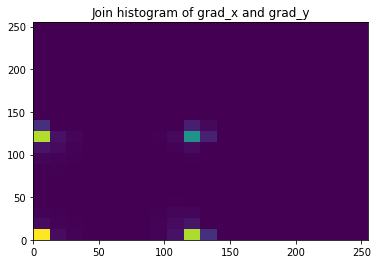

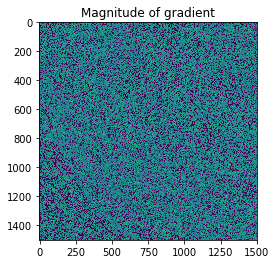

In [11]:
# Histogram of grad_x and grad_y
fig_hist_gxgy = plt.figure()
fig_hist_gxgy = plt.hist2d(gradX.flatten(),gradY.flatten(),20);
fig_hist_gxgy = plt.title('Join histogram of grad_x and grad_y')

temp_grad_gray = np.sqrt(gradX ** 2 + gradY **2)
fig_viz_grad_gray = plt.figure()
fig_viz_grad_gray = plt.imshow(temp_grad_gray)
fig_viz_grad_gray = plt.title('Magnitude of gradient')

In [12]:
# Find best gradient aggrement threshold
gradX_norm = scipy.linalg.norm(gradX.flatten())
gradY_norm = scipy.linalg.norm(gradY.flatten())
temp_TH_aggrement = {}
for tempTH in np.arange(0,255,5):
    tempGx, tempGy = np.gradient(tempImage < tempTH)
    tempGx_norm = scipy.linalg.norm(tempGx)
    tempGy_norm = scipy.linalg.norm(tempGy)
    if (tempGx_norm * tempGy_norm) != 0:
        temp_grad_aggrement_score = np.dot(tempGx.flatten(),gradX.flatten())/ ( tempGx_norm * gradX_norm ) + np.dot(tempGy.flatten(), gradY.flatten())/ ( tempGy_norm* gradY_norm )
    else:
        temp_grad_aggrement_score = 0
        #     temp_grad_aggrement_score = np.dot(tempGx.flatten(),gradX.flatten())+ np.dot(tempGy.flatten(), gradY.flatten())
    temp_TH_aggrement[tempTH] = temp_grad_aggrement_score    

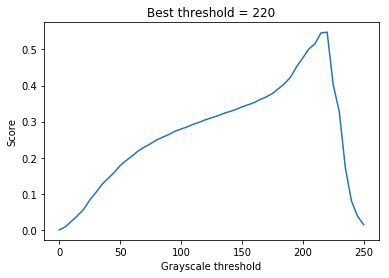

In [13]:
tempKeys, tempValues = zip(*sorted(temp_TH_aggrement.items()))
grad_threshold = tempKeys[np.argmax(tempValues)]
fig_grad_THscan_score = plt.figure()
fig_grad_THscan_score = plt.plot(tempKeys, tempValues)
fig_grad_THscan_score = plt.xlabel('Grayscale threshold')
fig_grad_THscan_score = plt.ylabel('Score')
fig_grad_THscan_score = plt.title('Best threshold = %s' % grad_threshold)

In [14]:
# Detected area
detected_total_area = np.sum(tempImage_BW)
detected_total_area_ratio = detected_total_area / float(crop_image_height * crop_image_width)
print('Total detected area ratio is %f' %detected_total_area_ratio)

Total detected area ratio is 0.141494


In [15]:
# Get image matrix of each patch 
patches = [tempImage[y - patch_half_size : y + patch_half_size, x - patch_half_size : x + patch_half_size].copy() for x, y in patch_center_pixel_location]
patches_num = len(patches)
patch_area = patch_size ** 2
patches_BW = [tempPatches <= otsu_thresh for tempPatches in patches]
patch_detected_area_ratio = np.array([np.sum(patches_BW[tempI])/float(patch_area) for tempI in range(len(patches))])

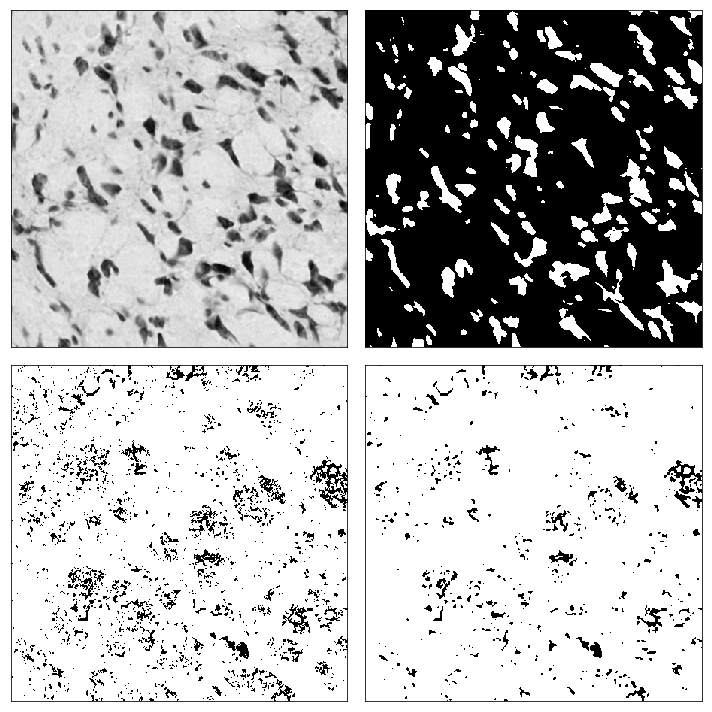

In [16]:
o_gass_filt_sigma = 1;
display_images_in_grids([patches[0],patches[0] < otsu_thresh, patches[0]<grad_threshold, 
                         ndi.filters.gaussian_filter(patches[0],o_gass_filt_sigma)<grad_threshold],nc=2, cmap=plt.cm.gray)

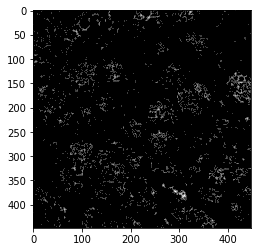

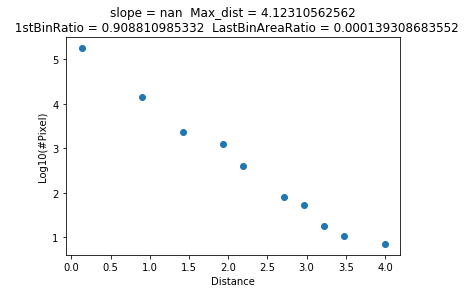

In [60]:
tempPatch = patches[0]
tempPatch_DT_features, tempPatch_DT_im = fun_patch_features_DT(tempPatch>grad_threshold,patch_area=patch_area,showImQ=True)

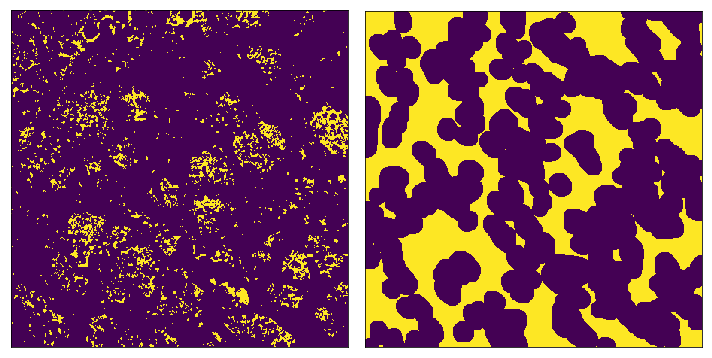

In [61]:
display_images_in_grids([tempPatch_DT_im  >= skimage.filters.threshold_otsu(tempPatch_DT_im),
                         tempPatch_DT_im_o  >= skimage.filters.threshold_otsu(tempPatch_DT_im_o)],nc=2)

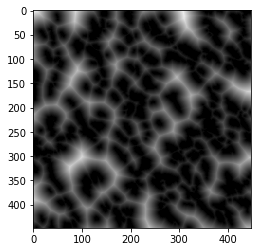

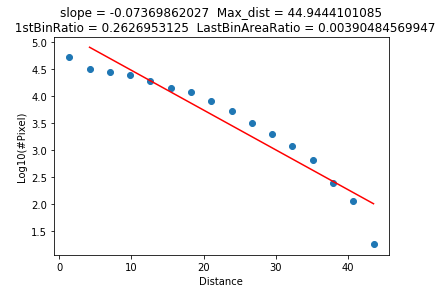

In [62]:
tempPatch_DT_features_o ,tempPatch_DT_im_o = fun_patch_features_DT(tempPatch > otsu_thresh, patch_area=patch_area, showImQ=True)

### Conclusion 1 - gradient-matching threshold without gaussian filter
1. Threshold found by gradient aggrement is not a good threshold to detect cells. Here, this threshold is applied to an area with holes and cells. The thresholded image miss bassically all the cells while it stable fail to detect the holes. 
2. This threshold is found by global gradient aggrement. Let's try local gradient next. 
3. The resulting BW image might be useful for further processing using distance transformation. 

## Gradient Match - After global gaussian filter

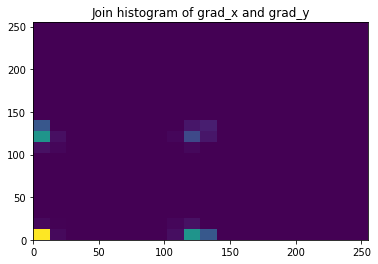

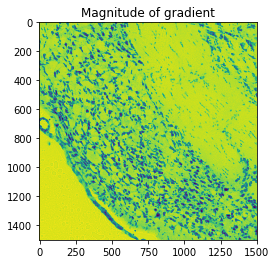

In [126]:
o_gass_filt_sigma = 2
tempImage_gf = ndi.filters.gaussian_filter(tempImage, o_gass_filt_sigma)

gradX_gf, gradY_gf = np.gradient(tempImage_gf)
fig_hist_gxgy_gf = plt.figure()
fig_hist_gxgy_gf = plt.hist2d(gradX_gf.flatten(),gradY_gf.flatten(),20);
fig_hist_gxgy_gf = plt.title('Join histogram of grad_x and grad_y')

temp_grad_gray_gf = np.sqrt(gradX_gf ** 2 + gradY_gf **2)
fig_viz_grad_gray_gf = plt.figure()
fig_viz_grad_gray_gf = plt.imshow(tempImage_gf)
fig_viz_grad_gray_gf = plt.title('Magnitude of gradient')

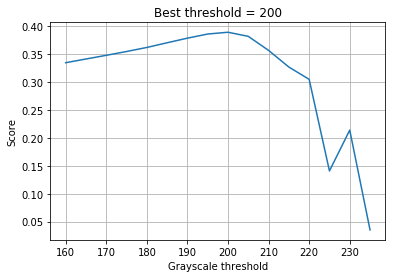

In [127]:
# Find best gradient aggrement threshold
gradX_norm_gf = scipy.linalg.norm(gradX_gf.flatten())
gradY_norm_gf = scipy.linalg.norm(gradY_gf.flatten())
temp_TH_aggrement_gf = {}
for tempTH in np.arange(160,240,5):
    tempGx, tempGy = np.gradient(tempImage_gf < tempTH)
    tempGx_norm = scipy.linalg.norm(tempGx)
    tempGy_norm = scipy.linalg.norm(tempGy)
    if (tempGx_norm * tempGy_norm) != 0:
        temp_grad_aggrement_score = np.dot(tempGx.flatten(),gradX_gf.flatten())/ ( tempGx_norm * gradX_norm_gf ) + np.dot(tempGy.flatten(), gradY_gf.flatten())/ ( tempGy_norm* gradY_norm_gf )
    else:
        temp_grad_aggrement_score = 0
        #     temp_grad_aggrement_score = np.dot(tempGx.flatten(),gradX.flatten())+ np.dot(tempGy.flatten(), gradY.flatten())
    temp_TH_aggrement_gf[tempTH] = temp_grad_aggrement_score  

tempKeys_gf, tempValues_gf = zip(*sorted(temp_TH_aggrement_gf.items()))
grad_threshold_gf = tempKeys_gf[np.argmax(tempValues_gf)]
fig_grad_THscan_score_gf = plt.figure()
fig_grad_THscan_score_gf = plt.plot(tempKeys_gf, tempValues_gf)
fig_grad_THscan_score_gf = plt.xlabel('Grayscale threshold')
fig_grad_THscan_score_gf = plt.ylabel('Score')
fig_grad_THscan_score_gf = plt.title('Best threshold = %s' % grad_threshold_gf)
fig_grad_THscan_score_gf = plt.grid(True)

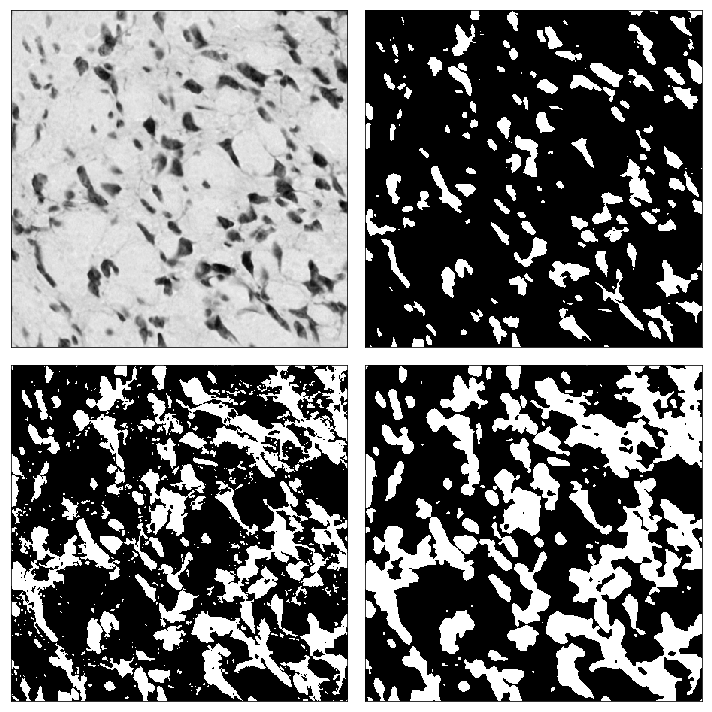

In [130]:
display_images_in_grids([patches[0],patches[0] < otsu_thresh, patches[0]<grad_threshold_gf, 
                         ndi.filters.gaussian_filter(patches[0],o_gass_filt_sigma)<grad_threshold_gf],nc=2, cmap=plt.cm.gray)

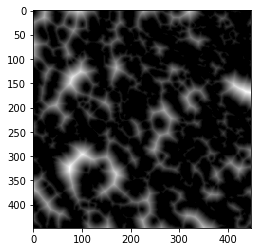

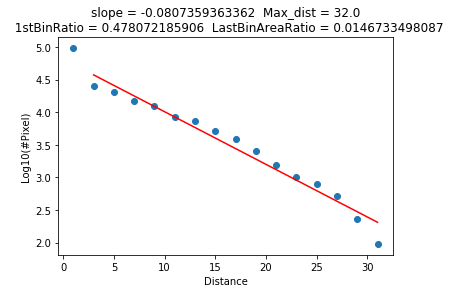

In [131]:
tempPatch = patches[0]
tempPatch_gs = ndi.filters.gaussian_filter(tempPatch, o_gass_filt_sigma)
tempPatch_DT_features, tempPatch_DT_im = fun_patch_features_DT(tempPatch_gs>grad_threshold_gf,patch_area=patch_area,showImQ=True)

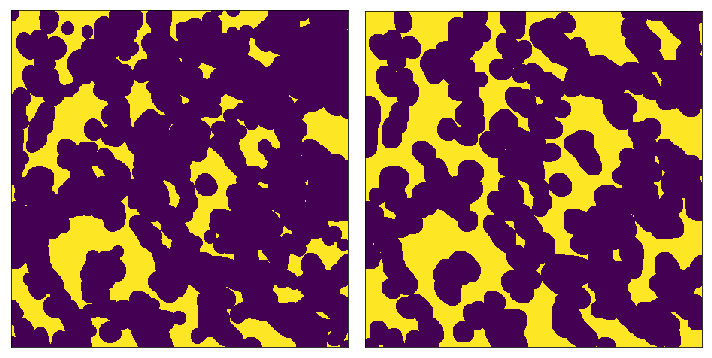

In [132]:
tempPatch_DT_im_BW = tempPatch_DT_im  >= skimage.filters.threshold_otsu(tempPatch_DT_im)
tempPatch_DT_im_o_BW = tempPatch_DT_im_o  >= skimage.filters.threshold_otsu(tempPatch_DT_im_o)
display_images_in_grids([tempPatch_DT_im_BW,tempPatch_DT_im_o_BW],nc=2)

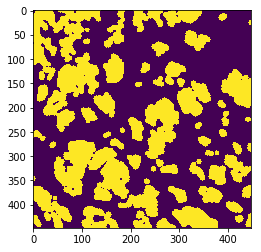

In [83]:
o_selem = skimage.morphology.disk(5)
plt.imshow(skimage.morphology.dilation(tempPatch_DT_im_BW,selem=o_selem))

### Conclusion 2 - gradient-matching threshold with gaussian filter
1. After gaussian filter, the gradient-matching threshold gives a good segmentation of the images. Compare with Otsu threshold, this method gives more detailed boundary. The best-alignment threshold depends on the size of the gaussian filter. 
    size_of_filter =   0    1    2    3    4  
    best_threshold = 218  218  200  195  190  
   Maybe a r = 2 gaussian filter filts out some not important details. Further increaseing the size of the gaussian filter will blur the boundary of the textures. Here we keed the size of the gaussian filter to be 2. 
2. The threshold found by gradient matching is generally higher than that of the otsu method. The reason might be that the color of the stained neuron is not uniform over the whole cell and the gradient-matching method pick up the cells with their boundarys. As a result, more cells are connected with each other on the BW images and thus gradient matching itself is not a good method to detect cells. 